# Cross Validation
This notebook describes how to do cross validation with simulation models.

In [1]:
%matplotlib inline
import tellurium as te
import numpy as np
import lmfit   # Fitting lib
import math
import random 
import matplotlib.pyplot as plt

In [2]:
# Experimental conditions
sim_time = 30
num_points = 10
noise_std = 1.5
num_folds = 3

In [3]:
# The simulation model
rr = te.loada("""
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.15
     k2 = 0.2
""")

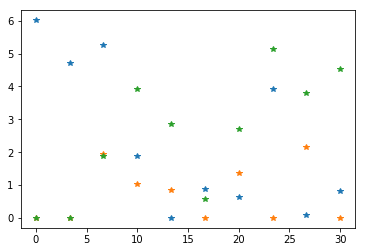

In [4]:
# Create the experimental data. We refer to these as the observations
rr.reset()
data = rr.simulate(0, sim_time, num_points)
num_cols = len(data.colnames) - 1

# Create some 'experimental' data 
x_data = data[:, 0]  # Times
obs_data = data[:,1:]   # Values of chemical species

for i in range (num_points):
    for j in range(num_cols):
        obs_data[i, j] = max(obs_data[i, j] + np.random.normal(0, noise_std, 1), 0) 

# Plot it to see what it looks like
plt.plot (x_data, obs_data, marker='*', linestyle='None')
plt.show()


In [5]:
# Generates indices of training and test data
def foldGenerator(num_points, num_folds):
   indices = range(num_points)
   for remainder in range(num_folds):
       test_indices = []
       for idx in indices:
         if idx % num_folds == remainder:
           test_indices.append(idx)
       train_indices = np.array(
           list(set(indices).difference(test_indices)))
       test_indices = np.array(test_indices)
       yield train_indices, test_indices

In [6]:
# Define the parameters present
parameters = lmfit.Parameters()
parameters.add('k1', value=1, min=0, max=10)
parameters.add('k2', value=1, min=0, max=10)

In [7]:
np.reshape(data, 4*num_points, 1)

[ 0.          3.33333333  6.66666667 10.         13.33333333 16.66666667
 20.         23.33333333 26.66666667 30.          6.01482123  4.71311106
  5.25822157  1.89327075  0.          0.87526918  0.62906802  3.92341808
  0.08015336  0.82551433  0.          0.          1.94119032  1.02799904
  0.85286142  0.          1.36596228  0.          2.14625841  0.
  0.          0.          1.89595981  3.93002865  2.87129463  0.57241379
  2.69836737  5.13713719  3.79763085  4.53111877]

In [8]:
# The current training indices are in train_indices
train_indices = range(num_points)  # Will be reset during cross validation

# Some useful functions

def reshapeData(matrix, indices, first_col=0):
    """
    Structures as an array all of the columns
    """
    num_columns = np.shape(matrix)[1] - first_col
    trimmed_matrix = matrix[indices, first_col:]
    return np.reshape(trimmed_matrix, num_columns*len(indices))

def vectorDifference(matrix1, matrix2, indices):
    """
    Linearizes the vectors and computes the difference between them
    for the specified indices.
    """
    array1 = reshapeData(matrix1, indices)
    array2 = reshapeData(matrix2, indices)
    return (array1 - array2)

def calcResiduals(parameters):
    """
    Runs a simulation with the specified parameters and calculates residuals
    for the train_indices.
    """
    sim_data = runSimulation(parameters)
    sim_data = sim_data[:, 1:]  # Skip time
    return vectorDifference(obs_data, sim_data, train_indices)

def runSimulation(parameters):
    """
    Runs the simulation model rr for the parameters.
    Returns the simulation data
    """
    rr.reset()
    parameter_dict = parameters.valuesdict()
    rr.k1 = parameter_dict['k1']
    rr.k2 = parameter_dict['k2']
    return rr.simulate (0, sim_time, num_points)


In [9]:
fold_generator = foldGenerator(num_points, num_folds)
result_parameters = []
result_rsqs = []
for fold_train_indices, fold_test_indices in fold_generator:
    global train_indices 
    train_indices = fold_train_indices
    # Set the parameters
    parameters = lmfit.Parameters()
    parameters.add('k1', value=1, min=0, max=10)
    parameters.add('k2', value=1, min=0, max=10)
    # Estimate the parameters for this fold
    fitter = lmfit.Minimizer(calcResiduals, parameters)
    fitter_result = fitter.minimize(method='leastsq')
    result_parameters.append(fitter_result.params)
    # Run the simulation using
    # the parameters estimated using the training data.
    test_estimates = runSimulation(fitter_result.params)
    test_estimates = test_estimates[:, 1:]
    # Calculate RSQ
    test_residuals = vectorDifference(obs_data, test_estimates, fold_test_indices)
    rsq = 1 - np.var(test_residuals)/np.var(reshapeData(obs_data, fold_test_indices))
    result_rsqs.append(rsq)
    

In [10]:
result_rsqs

[0.8031911675412468, -0.4584368794823437, 0.17682392752015952]

In [11]:
result_parameters

[Parameters([('k1',
              <Parameter 'k1', value=0.06454112587956196 +/- 0.0191, bounds=[0:10]>),
             ('k2',
              <Parameter 'k2', value=0.215828418860875 +/- 0.163, bounds=[0:10]>)]),
 Parameters([('k1',
              <Parameter 'k1', value=7.4385928272982245 +/- 0.121, bounds=[0:10]>),
             ('k2',
              <Parameter 'k2', value=0.07294291354191185 +/- 0.00284, bounds=[0:10]>)]),
 Parameters([('k1',
              <Parameter 'k1', value=0.08204776227086208 +/- 0.0191, bounds=[0:10]>),
             ('k2',
              <Parameter 'k2', value=0.44206111181955443 +/- 0.432, bounds=[0:10]>)])]